Global Parameters: 
 cross val= 1 , binning= 1 , bin ct= 2 , feature selected= 1 , fs type= 4 , grid search= 0
['target', 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Header of target variable:  target
303 303


--FEATURE SELECTION ON-- 

Wrapper Select - SVC: 
Features Selected: ['sex', 'cp', 'fbs', 'exang', 'slope', 'ca', 'thal'] 
 Features Removed: ['age', 'trestbps', 'chol', 'restecg', 'thalach', 'oldpeak']
Features (total/selected): 13 7


--ML Model Output-- 

Parameters:  {'activation': 'logistic', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (25,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 0, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'war

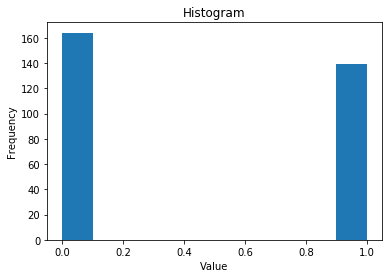

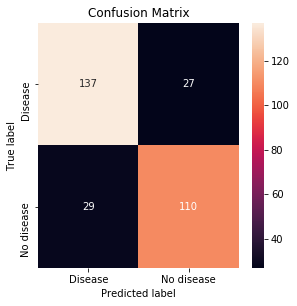

In [39]:
############################################################################################################ 
#
#                                      DSC 540 PROJECT
#                                    HEART DISEASE DATASET
#
############################################################################################################ 

#Michal Chowaniak


import sys
import csv
import math
import numpy as np
from operator import itemgetter
import time
import copy

from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification 
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.externals import joblib
from sklearn.feature_selection import RFE, VarianceThreshold, SelectFromModel
from sklearn.feature_selection import SelectKBest, mutual_info_regression, mutual_info_classif, chi2
from sklearn import metrics
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.preprocessing import KBinsDiscretizer, scale
from tempfile import TemporaryFile
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Handle annoying warnings
import warnings, sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.ConvergenceWarning)


############################################################################################################ 
#
#                                      Global parameters
#
############################################################################################################ 



#Set global model parameters
target_idx=0                                       #Index of Target variable
cross_val=1                                         #Control Switch for CV
norm_target=0                                       #Normalize target switch
norm_features=0                                     #Normalize target switch
binning=1                                           #Control Switch for Bin Target
bin_cnt=2                                           #If bin target, this sets number of classes
feat_select=1                                       #Control Switch for Feature Selection
fs_type=4  #4                                           #Feature Selection type: 
                                                        # 1=Stepwise Backwards Removal, 
                                                        # 2=Wrapper Select via model Random Forest
                                                        # 3=Wrapper Select via model Gradient Boosting
                                                        # 4=Wrapper Select via model SVC
                                                        # 5=Univariate Feature Selection - Chi-squared
                                                        # 6=Full-blown Wrapper Select (from any kind of ML model)
lv_filter=0                                         #Control switch for low variance filter on features
feat_start=1                                        #Start column of features
k_cnt=7                                             #Number of 'Top k' best ranked features to select, only applies for fs_types 1 and 3
gridsearchcv=0    #1                                  #control switch for grid search cv 
rand_st=0                                           #Set Random State variable for randomizing splits on runs

# run only certain models
dtcv = 1                                            #decistion tree, cross validation only
rfcv = 0                                            #random forest, cross validation only
gdcv = 0                                            #gradient boosting, cross validation only   
abcv = 0                                            #ada boost, cross validation only
nncv = 0                                            #neural network, cross validation only
svmcv = 0                                           #svm, cross validation only




print ('Global Parameters: \n',
        'cross val=',cross_val,
        ', binning=',binning, 
        ', bin ct=', bin_cnt, 
        ', feature selected=', feat_select,
        ', fs type=',fs_type,
        ', grid search=',gridsearchcv)


############################################################################################################ 
#
#                                        Wrapper Feat Select Helper
#
############################################################################################################ 



#Recursive Function for searching thru feature space
def feat_space_search(arr, curr_idx):
    '''Setup currently as exhuastive search, but could be changed to use
       greedy search, random search, genetic algorithms, etc. ... also
       no regularization, so probably selects more features than necessary'''
    global roll_idx, combo_ctr, best_score, sel_idx
    
    if curr_idx==feat_cnt:
        #If end of feature array, roll thru combinations
        roll_idx=roll_idx+1
        print ("Combos Searched so far:", combo_ctr, "Current Best Score:", best_score)
        for i in range(roll_idx, len(arr)):
            arr[i]=0
        if roll_idx<feat_cnt-1:
            feat_space_search(arr, roll_idx+1)                                                                      #Recurse till end of rolls
        
    else:
        #Else setup next feature combination and calc performance
        arr[curr_idx]=1
        data=data_np#_wrap                                                                                          #Temp array to hold data
        temp_del=[i for i in range(len(arr)) if arr[i]==0]                                                          #Pick out features not in this combo, and remove
        data = np.delete(data, temp_del, axis=1)
        data_train, data_test, target_train, target_test = train_test_split(data, target_np, test_size=0.35)                

        if binning==1:
            if bin_cnt<=2:
                scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}
                scores = cross_validate(clf, data_np, target_np, scoring=scorers, cv=5) 
                score = scores['test_roc_auc'].mean()                                                               #AUC
            else:
                sscorers = {'Accuracy': 'accuracy'}
                scores = cross_validate(clf, data_np, target_np, scoring=scorers, cv=5) 
                score = scores['test_Accuracy'].mean()                                                              #Accuracy
            print('Acc/AUC:', curr_idx, feat_arr, len(data[0]), score)
            if score>best_score:                                                                                    #Compare performance and update sel_idx and best_score, if needed
                best_score=score
                sel_idx=copy.deepcopy(arr) 
                
        if binning==0:
            scorers = {'Neg_MSE': 'neg_mean_squared_error', 'expl_var': 'explained_variance'}
            scores = cross_validate(rgr, data, target_np, scoring=scorers, cv=5)    
            score = np.asarray([math.sqrt(-x) for x in scores['test_Neg_MSE']]).mean()                              #RMSE
            print('RMSE:', curr_idx, feat_arr, len(data[0]), score)
            if score<best_score:                                                                                    #Compare performance and update sel_idx and best_score, if needed
                best_score=score
                sel_idx=copy.deepcopy(arr) 

        #move to next feature index and recurse
        combo_ctr+=1  
        curr_idx+=1
        feat_space_search(arr, curr_idx)                                                                            #Recurse till end of iteration for roll



############################################################################################################ 
#
#                                        Load Data
#
############################################################################################################ 

file1= csv.reader(open('DataSet/processedcleveland2.csv'), delimiter=',', quotechar='"')
#file1= csv.reader(open('Feature Selection/processedclevelandfeatures.csv'), delimiter=',', quotechar='"')

#Read Header Line
header=next(file1)

#Read data
data=[]
target=[]
for row in file1:
    #Load Target
    if row[target_idx]=='':                         #If target is blank, skip row                       
        continue
    else:
        target.append(float(row[target_idx]))       #If pre-binned class, change float to int

    #Load row into temp array, cast columns  
    temp=[]
                 
    for j in range(feat_start,len(header)):
        if row[j]=='':
            temp.append(float())
        else:
            try:
                temp.append(float(row[j]))               
            except ValueError:
                temp.append(9999)
                                
    #Load temp into Data array
    data.append(temp)
    
    
print(header)
print ("Header of target variable: ", header[target_idx])
print(len(target),len(data))
#for i in range(10):
#    print(target[i])
#    print(data[i])
print('\n')


data_np=np.asarray(data)

#replace missign values with median value
imp = SimpleImputer(missing_values=9999, strategy='median')
imp.fit(data_np)
data_np=imp.transform(data_np)


#save data to a file
#np.savetxt("test.csv", data_np, delimiter=",")
#np.savetxt("testcorrected.csv", imp.transform(data_np), delimiter=",")

target_np=np.asarray(target)

#print (target_np)


############################################################################################################ 
#
#                                        Preprocess data
#
############################################################################################################ 


#recode values 2,3,4 as 1
#0 = no disease, 1=disease present

target_np[target_np > 1] = 1
#print (target_np)

#target histogram
plt.hist(target_np)
plt.title("Histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")
#plt.xticks([0,1])


#barplot(target_np)
#hist(taget_np)



if norm_target==1:
    #Target normalization for continuous values
    target_np=scale(target_np)

if norm_features==1:
    #Feature normalization for continuous values
    data_np=scale(data_np)

'''if binning==1:
    
    #Discretize Target variable with KBinsDiscretizer
    enc = KBinsDiscretizer(n_bins=[bin_cnt], encode='ordinal', strategy='quantile')         #Strategy here is important, quantile creating equal bins, but kmeans prob being more valid "clusters"
    target_np_bin = enc.fit_transform(target_np.reshape(-1,1))

    #Get Bin min/max
    temp=[[] for x in range(bin_cnt+1)]
    for i in range(len(target_np)):
        for j in range(bin_cnt):
            if target_np_bin[i]==j:
                temp[j].append(target_np[i])

    print (temp, "*****test" )
    for j in range(bin_cnt):
        print('Bin', j, ':', min(temp[j]), max(temp[j]), len(temp[j]))
    print('\n')

    #Convert Target array back to correct shape
    target_np=np.ravel(target_np_bin)'''


############################################################################################################ 
#
#                                        Feature Selection
#
############################################################################################################ 


#Low Variance Filter
if lv_filter==1:
    print('--LOW VARIANCE FILTER ON--', '\n')
    
    #LV Threshold
    sel = VarianceThreshold(threshold=0.5)                                      #Removes any feature with less than 20% variance
    fit_mod=sel.fit(data_np)
    fitted=sel.transform(data_np)
    sel_idx=fit_mod.get_support()

    #Get lists of selected and non-selected features (names and indexes)
    temp=[]
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(header[i+feat_start])
            temp_idx.append(i)
        else:                                                                       #Indexes of non-selected features get added to delete array
            temp_del.append(i)

    print('Selected', temp)
    print('Features (total, selected):', len(data_np[0]), len(temp))
    print('\n')

    #Filter selected columns from original dataset
    header = header[0:feat_start]
    for field in temp:
        header.append(field)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index


#Feature Selection
if feat_select==1:
    '''Three steps:
       1) Run Feature Selection
       2) Get lists of selected and non-selected features
       3) Filter columns from original dataset
       '''
    
    print('--FEATURE SELECTION ON--', '\n')
    
    ##1) Run Feature Selection #######
    if fs_type==1:
        #Stepwise Recursive Backwards Feature removal
        if binning==1:
            clf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='entropy', random_state=None)
            sel = RFE(clf, n_features_to_select=k_cnt, step=.1)
            print('Stepwise Recursive Backwards - Random Forest: ')
        if binning==0:
            rgr = RandomForestRegressor(n_estimators=500, max_depth=None, min_samples_split=3, criterion='mse', random_state=None)
            sel = RFE(rgr, n_features_to_select=k_cnt, step=.1)
            print('Stepwise Recursive Backwards - Random Forest: ')
            
        fit_mod=sel.fit(data_np, target_np)
        print(sel.ranking_)
        sel_idx=fit_mod.get_support()      

    if fs_type==2:
        #Wrapper Select via model Random Forest
        if binning==1:
            clf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='entropy', random_state=None)
            sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)                                                           #to select only based on max_features, set to integer value and set threshold=-np.inf
            print ('Wrapper Select - Random Forest: ')
        if binning==0:
            rgr = RandomForestRegressor(n_estimators=500, max_features=.33, max_depth=None, min_samples_split=3, criterion='mse', random_state=None)
            sel = SelectFromModel(rgr, prefit=False, threshold='mean', max_features=None)
            print ('Wrapper Select - Random Forest: ')
            
        fit_mod=sel.fit(data_np, target_np)
        #print(sel.ranking_)
        sel_idx=fit_mod.get_support()
    
    
    if fs_type==3:
        #Wrapper Select via model Gradient Boosting
        if binning==1:
            clf = GradientBoostingClassifier(n_estimators=100, loss= 'deviance', learning_rate=0.1, max_depth=3, min_samples_split=3, random_state=rand_st)    
            sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)                                                           #to select only based on max_features, set to integer value and set threshold=-np.inf
            print ('Wrapper Select - Gradient Boosting: ')
        if binning==0:
            rgr = GradientBoostingRegressor(n_estimators=100, loss='ls', learning_rate=0.1, max_depth=3, min_samples_split=3, random_state=rand_st)        
            sel = SelectFromModel(rgr, prefit=False, threshold='mean', max_features=None)
            print ('Wrapper Select - Gradient Boosting: ')
            
        fit_mod=sel.fit(data_np, target_np)
        sel_idx=fit_mod.get_support()
    
        
    if fs_type==4:
        #Wrapper Select via model SVC
        if binning==1:
            clf = SVC(kernel='linear', gamma= 'scale', C=1.0, probability=True, random_state=rand_st) #'''Replace comment HERE'''
            sel = SelectFromModel(clf, prefit=False, threshold='mean', max_features=None)                                                           #to select only based on max_features, set to integer value and set threshold=-np.inf
            print ('Wrapper Select - SVC: ')
        if binning==0:
            rgr = '''Unused in this homework'''
            sel = SelectFromModel(rgr, prefit=False, threshold='mean', max_features=None)
            print ('Wrapper Select - SVC: ')
            
        fit_mod=sel.fit(data_np, target_np) 
        sel_idx=fit_mod.get_support()
    

    if fs_type==5:       
        if binning==1:                                                              ######Only work if the Target is binned###########
            #Univariate Feature Selection - Chi-squared
            sel=SelectKBest(chi2, k=k_cnt)
            fit_mod=sel.fit(data_np, target_np)                                         #will throw error if any negative values in features, so turn off feature normalization, or switch to mutual_info_classif
            print ('Univariate Feature Selection - Chi2: ')
            sel_idx=fit_mod.get_support()

        if binning==0:                                                              ######Only work if the Target is continuous###########
            #Univariate Feature Selection - Mutual Info Regression
            sel=SelectKBest(mutual_info_regression, k=k_cnt)
            fit_mod=sel.fit(data_np, target_np)
            print ('Univariate Feature Selection - Mutual Info: ')
            sel_idx=fit_mod.get_support()

        #Print ranked variables out sorted
        temp=[]
        scores=fit_mod.scores_
        for i in range(feat_start, len(header)):            
            temp.append([header[i], float(scores[i-feat_start])])

        print('Ranked Features')
        temp_sort=sorted(temp, key=itemgetter(1), reverse=True)
        for i in range(len(temp_sort)):
            print(i, temp_sort[i][0], ':', temp_sort[i][1])
        print('\n')

    if fs_type==6:
        #Full-blown Wrapper Select (from any kind of ML model)        
        if binning==1:                                                              ######Only work if the Target is binned###########
            start_ts=time.time()
            sel_idx=[]                                                                                      #Empty array to hold optimal selected feature set
            best_score=0                                                                                    #For classification compare Accuracy or AUC, higher is better, so start with 0
            feat_cnt=len(data_np[0])
            #Create Wrapper model
            clf = SVC(kernel='linear', gamma= 'scale', C=1.0, probability=True, random_state=rand_st)                                #This could be any kind of classifier model
      
        if binning==0:                                                              ######Only work if the Target is continuous###########
            start_ts=time.time()
            sel_idx=[]                                                                                      #Empty array to hold optimal selected feature set
            best_score=sys.float_info.max                                                                   #For regression compare RMSE, lower is better, so start with max sys float value
            feat_cnt=len(data_np[0])
            #Create Wrapper model
            rgr = SVR(kernel='linear', gamma=0.1, C=1.0)#'''Replace comment HERE'''                    #This could be any kind of regressor model         
        
        #Loop thru feature sets
        roll_idx=0
        combo_ctr=0
        feat_arr=[0 for col in range(feat_cnt)]                                         #Initialize feature array
        for idx in range(feat_cnt):
            roll_idx=idx
            feat_space_search(feat_arr, idx)                                           #Recurse
            feat_arr=[0 for col in range(feat_cnt)]                                     #Reset feature array after each iteration
        
        print('# of Feature Combos Tested:', combo_ctr)
        print(best_score, sel_idx, len(data_np[0]))
        print("Wrapper Feat Sel Runtime:", time.time()-start_ts)
             
        
     ##2) Get lists of selected and non-selected features (names and indexes) #######
    temp, temp4 = ([] for i in range(2))
    temp_idx=[]
    temp_del=[]
    for i in range(len(data_np[0])):
        if sel_idx[i]==1:                                                           #Selected Features get added to temp header
            temp.append(header[i+feat_start])
            temp_idx.append(i)
        else: 
            temp4.append(header[i+feat_start]) #Indexes of non-selected features get added to delete array
            temp_del.append(i)
    print('Features Selected:', temp, "\n" ,'Features Removed:', temp4)
    print('Features (total/selected):', len(data_np[0]), len(temp))
    print('\n')
            
                
    ##3) Filter selected columns from original dataset #########
    header = header[0:feat_start]
    for field in temp:
        header.append(field)
    data_np = np.delete(data_np, temp_del, axis=1)                                 #Deletes non-selected features by index)
    


############################################################################################################    
#
#                                          Train SciKit Models
#
#                                           Test/Train split
#
############################################################################################################


print('--ML Model Output--', '\n')

#Test/Train split
data_train, data_test, target_train, target_test = train_test_split(data_np, target_np, test_size=0.35)

####Classifiers####
if binning==1 and cross_val==0:
    #SciKit Decision Tree
    start_ts=time.time()
    clf = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=rand_st)
    clf.fit(data_train, target_train)
    param = clf.get_params()
    print ('Parameters: ', param)
    print('Decision Tree , test/tain, Acc: %0.2f'  %clf.score(data_test, target_test))
    if bin_cnt<=2:                                                                                                  #AUC only works with binary classes, not multiclass
        print('Decision Tree, test/tain, AUC: %0.2f' % metrics.roc_auc_score(target_test, clf.predict_proba(data_test)[:,1]))             
        #joblib.dump(clf, 'DecTree_DSC540_HW1.pkl')                     #Save and pickle model
    print("Decision Tree, test/tain, Runtime: ", time.time()-start_ts, "\n")
   
    
    
    #SciKit Random Forest
    start_ts=time.time()
    clf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='entropy', random_state=None)
    clf.fit(data_train, target_train)
    param = clf.get_params()
    print ('Parameters: ', param)
    print('Random Forest, test/tain,  Acc: %0.2f' % clf.score(data_test, target_test))
    if bin_cnt<=2:                                                                                                  #AUC only works with binary classes, not multiclass
        print('Random Forest , test/tain, AUC: %0.2f' % metrics.roc_auc_score(target_test, clf.predict_proba(data_test)[:,1])) 
    print("Random Forest , test/tain, Runtime:", time.time()-start_ts, "\n")
        
        

    #SciKit Gradient Boosting test/train split
    start_ts=time.time()
    clf = GradientBoostingClassifier(n_estimators=100, loss= 'deviance', learning_rate=0.1, max_depth=md, min_samples_split=3, random_state=rand_st)
    clf.fit(data_train, target_train)
    param = clf.get_params()
    print ('Parameters: ', param)
    print('Gradient Boosting, test/tain,  Acc: %0.2f' % clf.score(data_test, target_test))
    if bin_cnt<=2:                                                                                                  #AUC only works with binary classes, not multiclass
        print('Gradient Boosting , test/tain, AUC: %0.2f' % metrics.roc_auc_score(target_test, clf.predict_proba(data_test)[:,1]))
    print("Gradient Boosting , test/tain, Runtime:", time.time()-start_ts, "\n")
        
    #SciKit ADA Boost test/train split
    start_ts=time.time()
    clf = AdaBoostClassifier(n_estimators=100, base_estimator = None, learning_rate=0.1, random_state=rand_st)
    clf.fit(data_train, target_train)
    param = clf.get_params()
    print ('Parameters: ', param)
    print('ADA Boost, test/tain,  Acc: %0.2f' % clf.score(data_test, target_test))
    if bin_cnt<=2:                                                                                                  #AUC only works with binary classes, not multiclass
        print('ADA Boost , test/tain, AUC: %0.2f' % metrics.roc_auc_score(target_test, clf.predict_proba(data_test)[:,1]))
    print("ADA Boost, test/tain,Runtime:", time.time()-start_ts, "\n")
    
    #SciKit Neral Network test/train split
    start_ts=time.time()
    clf = MLPClassifier(activation= 'logistic', solver= 'adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(10, ), random_state=rand_st )
    clf.fit(data_train, target_train)
    param = clf.get_params()
    print ('Parameters: ', param)
    print('Neural Network, test/tain,  Acc: %0.2f' % clf.score(data_test, target_test))
    if bin_cnt<=2:                                                                                                  #AUC only works with binary classes, not multiclass
        print('Neural Network, test/tain,  AUC: %0.2f' % metrics.roc_auc_score(target_test, clf.predict_proba(data_test)[:,1]))
    print("Neural Network, test/tain, Runtime:", time.time()-start_ts, "\n")

    #SciKit CVS test/train split
    start_ts=time.time()
    clf = SVC(kernel='linear', gamma= 'scale', C=1.0, probability=True, random_state=rand_st)
    clf.fit(data_train, target_train)
    param = clf.get_params()
    print ('Parameters: ', param)
    print('SVC , test/tain,  Acc: %0.2f' % clf.score(data_test, target_test))
    if bin_cnt<=2:                                                                                                  #AUC only works with binary classes, not multiclass
        print('SVC, test/tain, AUC: %0.2f' % metrics.roc_auc_score(target_test, clf.predict_proba(data_test)[:,1]))
    print("SVC , test/tain, Runtime:", time.time()-start_ts, "\n")

    
############################################################################################################    
#
#                                         Train and Test SciKit Models
#
#                                 Binning and Cross-Valalidation Classifiers
#
############################################################################################################


if binning==1 and cross_val==1 and gridsearchcv ==0: 
    
    
    #Setup Crossval classifier scorers
    if bin_cnt<=2:
        #scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}
        scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc', 'Recall': 'recall', 'Precision': 'precision' }
    else:
        scorers = {'Accuracy': 'accuracy'}

     
    
    
    if dtcv ==1:
        #SciKit Decision Tree - Cross Val
        start_ts=time.time()
        clf = DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=rand_st)
        param = clf.get_params()
        print ('Parameters: ', param)
        scores = cross_validate(clf, data_np, target_np, scoring=scorers, cv=5)
        scores_Acc = scores['test_Accuracy']
        print("Decision Tree, cross validation, Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))        
        if bin_cnt<=2:                                                                                                  #Only works with binary classes, not multiclass
            scores_AUC= scores['test_roc_auc']
            scores_Recall = scores['test_Recall']
            scores_Precis = scores['test_Precision']
            print("Decision Tree, cross validation, AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))                           
            print("Decision Tree, cross validation, Recall: %0.2f (+/- %0.2f)" % (scores_Recall.mean(), scores_Recall.std() * 2))
            print("Decision Tree, cross validation, Precision: %0.2f (+/- %0.2f)" % (scores_Precis.mean(), scores_Precis.std() * 2))
        print("Decision Tree, cross validation, Runtime:", time.time()-start_ts, "\n")
        #print(scores.keys())
      
    
#         #confusion matrix test data
#         print('\n')
#         clf_fit = clf.fit(data_train, target_train)
#         predictions = clf_fit.predict(data_test)
#         cm = confusion_matrix(target_test, predictions)
#         print("Confusion Matrix on test set 35%: \n", cm)
#         print('\n')
#         #Plot confusion matrix
#         df = pd.DataFrame(cm, index = ['heart disease', 'no heart disease'], columns = ['heart disease', 'no heart disease'])
#         plt.figure(figsize=(4,4))
#         sns.heatmap(df, annot=True)
#         plt.title('Confusion Matrix')
#         plt.ylabel('True label')
#         plt.xlabel('Predicted label')
#         plt.show()
#         print('\n')
    
 

        #confusion matrix all data
        print('\n', 'Confusion matrix whole dataset')
        clf_fit = clf.fit(data_np, target_np)
        predictions = clf_fit.predict(data_np)
        cm = confusion_matrix(target_np, predictions)
        #print("Confusion Matrix on test set 35%: \n", cm)
        print('\n')
        #Plot confusion matrix
        df = pd.DataFrame(cm, index = ['Disease', 'No disease'], columns = ['Disease', 'No disease'])
        print(df)
        plt.figure(figsize=(4.5,4.5))
        sns.heatmap(df, annot=True, fmt='.0f')
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
        print('\n')


#         #confusion matrix all data
#         print('\n', 'confusion matrix all data')
#         clf_fit = clf.fit(data_np, target_np)
#         predictions = clf_fit.predict(data_np)
#         cm = confusion_matrix(target_np, predictions)
#         print("Confusion Matrix on test set 35%: \n", cm)
#         print('\n')
#         #Plot confusion matrix
#         df = pd.DataFrame(cm, index = ['Disease', 'No disease'], columns = ['Disease', 'No disease'])
#         print (df)
        
#         s= df.sum().sum()
#         print (s)
#         dfperc = df/s
#         print (dfperc)
        
#         plt.figure(figsize=(4.5,4.5))
#         sns.heatmap(dfperc, annot=True, fmt='.2%')
#         #for t in ax.texts: t.set_text(t.get_text() + " %")
               
#         plt.title('Confusion Matrix %')
#         plt.ylabel('True label')
#         plt.xlabel('Predicted label')
#         plt.show()
#         print('\n')
        
        
        
        
    if rfcv ==1:
        #SciKit Random Forest - Cross Val
        start_ts=time.time()
        #clf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='entropy', random_state=None)
        #clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=3,criterion='entropy', random_state=None)
        #clf = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=3,criterion='entropy', random_state=None)
        #clf = RandomForestClassifier(n_estimators=500, max_depth=None, min_samples_split=3,criterion='entropy', random_state=None)
        #clf = RandomForestClassifier(n_estimators=800, max_depth=None, min_samples_split=3,criterion='entropy', random_state=None)
        #clf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=3,criterion='entropy', random_state=None)
        #clf = RandomForestClassifier(n_estimators=1500, max_depth=None, min_samples_split=3,criterion='entropy', random_state=None)
        #clf = RandomForestClassifier(n_estimators=2000, max_depth=None, min_samples_split=3,criterion='entropy', random_state=None)
        
        #clf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3, criterion='gini', random_state=None)
        #clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=3,criterion='gini', random_state=None)
        #clf = RandomForestClassifier(n_estimators=300, max_depth=None, min_samples_split=3,criterion='gini', random_state=None)
        #clf = RandomForestClassifier(n_estimators=500, max_depth=None, min_samples_split=3,criterion='gini', random_state=None)
        #clf = RandomForestClassifier(n_estimators=800, max_depth=None, min_samples_split=3,criterion='gini', random_state=None)
        #clf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=3,criterion='gini', random_state=None)
        #clf = RandomForestClassifier(n_estimators=1500, max_depth=None, min_samples_split=3,criterion='gini', random_state=None)
        #clf = RandomForestClassifier(n_estimators=2000, max_depth=None, min_samples_split=3,criterion='gini', random_state=None)
        
        #clf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=2,criterion='entropy', random_state=None)
        #clf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=5,criterion='entropy', random_state=None)
        #clf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=8,criterion='entropy', random_state=None)
        #clf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=10,criterion='entropy', random_state=None)    
        #clf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=15,criterion='entropy', random_state=None)    
        #clf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=20,criterion='entropy', random_state=None)    
        clf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=30,criterion='entropy', random_state=None)    
        #clf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=40,criterion='entropy', random_state=None)    
        
        param = clf.get_params()
        print ('Parameters: ', param)
        scores = cross_validate(clf, data_np, target_np, scoring=scorers, cv=5)
        scores_Acc = scores['test_Accuracy']
        print("Random Forest, cross validation, Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))        
        if bin_cnt<=2:                                                                                                  #Only works with binary classes, not multiclass
            scores_AUC= scores['test_roc_auc']
            scores_Recall = scores['test_Recall']
            scores_Precis = scores['test_Precision']
            print("Random Forest, cross validation, AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))
            print("Random Forest, cross validation, Recall: %0.2f (+/- %0.2f)" % (scores_Recall.mean(), scores_Recall.std() * 2))
            print("Random Forest, cross validation, Precision: %0.2f (+/- %0.2f)" % (scores_Precis.mean(), scores_Precis.std() * 2))
        print("Random Forest, cross validation, Runtime:", time.time()-start_ts, "\n")

#         #confusion matrix
#         print('\n')
#         clf_fit = clf.fit(data_train, target_train)
#         predictions = clf_fit.predict(data_test)
#         cm = confusion_matrix(target_test, predictions)
#         print("Confusion Matrix on test set 35%: \n", cm)
#         print('\n')
#         #Plot confusion matrix
#         df = pd.DataFrame(cm, index = ['heart disease', 'no heart disease'], columns = ['heart disease', 'no heart disease'])
#         plt.figure(figsize=(4,4))
#         sns.heatmap(df, annot=True)
#         plt.title('Confusion Matrix')
#         plt.ylabel('True label')
#         plt.xlabel('Predicted label')
#         plt.show()
#         print('\n')
        
        #confusion matrix all data
        print('\n', 'Confusion matrix whole dataset')
        clf_fit = clf.fit(data_np, target_np)
        predictions = clf_fit.predict(data_np)
        cm = confusion_matrix(target_np, predictions)
        #print("Confusion Matrix on test set 35%: \n", cm)
        print('\n')
        #Plot confusion matrix
        df = pd.DataFrame(cm, index = ['Disease', 'No disease'], columns = ['Disease', 'No disease'])
        print(df)
        plt.figure(figsize=(4.5,4.5))
        sns.heatmap(df, annot=True, fmt='.0f')
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
        print('\n')
        
        
        
        
        
    if gdcv == 1:
        #SciKit Gradient Boosting - Cross Val
        #Number of trees, learning rate/step size, loss function deviance’, ‘exponential’, 
        #max depth of each tree 
        start_ts=time.time()
        #clf=GradientBoostingClassifier(n_estimators=100, loss= 'deviance', learning_rate=0.1, max_depth=3, min_samples_split=3, random_state=rand_st) #'''Replace comment HERE'''
        #clf=GradientBoostingClassifier(n_estimators=200, loss= 'deviance', learning_rate=0.1, max_depth=3, min_samples_split=3, random_state=rand_st)
        #clf=GradientBoostingClassifier(n_estimators=300, loss= 'deviance', learning_rate=0.1, max_depth=3, min_samples_split=3, random_state=rand_st)
        #clf=GradientBoostingClassifier(n_estimators=500, loss= 'deviance', learning_rate=0.1, max_depth=3, min_samples_split=3, random_state=rand_st)
        #clf=GradientBoostingClassifier(n_estimators=50, loss= 'deviance', learning_rate=0.1, max_depth=3, min_samples_split=3, random_state=rand_st)
        #clf=GradientBoostingClassifier(n_estimators=25, loss= 'deviance', learning_rate=0.1, max_depth=3, min_samples_split=3, random_state=rand_st)
        #clf=GradientBoostingClassifier(n_estimators=10, loss= 'deviance', learning_rate=0.1, max_depth=3, min_samples_split=3, random_state=rand_st)
        
        #clf=GradientBoostingClassifier(n_estimators=100, loss= 'exponential', learning_rate=0.1, max_depth=3, min_samples_split=3, random_state=rand_st) #'''Replace comment HERE'''
        #clf=GradientBoostingClassifier(n_estimators=200, loss= 'exponential', learning_rate=0.1, max_depth=3, min_samples_split=3, random_state=rand_st)
        #clf=GradientBoostingClassifier(n_estimators=300, loss= 'exponential', learning_rate=0.1, max_depth=3, min_samples_split=3, random_state=rand_st)
        #clf=GradientBoostingClassifier(n_estimators=500, loss= 'exponential', learning_rate=0.1, max_depth=3, min_samples_split=3, random_state=rand_st)
        #clf=GradientBoostingClassifier(n_estimators=50, loss= 'exponential', learning_rate=0.1, max_depth=3, min_samples_split=3, random_state=rand_st)
        #clf=GradientBoostingClassifier(n_estimators=25, loss= 'exponential', learning_rate=0.1, max_depth=3, min_samples_split=3, random_state=rand_st)
        #clf=GradientBoostingClassifier(n_estimators=10, loss= 'exponential', learning_rate=0.1, max_depth=3, min_samples_split=3, random_state=rand_st)
        
        #clf=GradientBoostingClassifier(n_estimators=25, loss= 'exponential', learning_rate=0.15, max_depth=3, min_samples_split=3, random_state=rand_st)
        #clf=GradientBoostingClassifier(n_estimators=25, loss= 'deviance', learning_rate=0.15, max_depth=3, min_samples_split=3, random_state=rand_st)
        #clf=GradientBoostingClassifier(n_estimators=25, loss= 'deviance', learning_rate=0.2, max_depth=3, min_samples_split=3, random_state=rand_st)
        #clf=GradientBoostingClassifier(n_estimators=25, loss= 'deviance', learning_rate=0.05, max_depth=3, min_samples_split=3, random_state=rand_st)
        
        #clf=GradientBoostingClassifier(n_estimators=25, loss= 'exponential', learning_rate=0.1, max_depth=2, min_samples_split=3, random_state=rand_st)
        #clf=GradientBoostingClassifier(n_estimators=25, loss= 'deviance', learning_rate=0.1, max_depth=2, min_samples_split=3, random_state=rand_st)
        
        #clf=GradientBoostingClassifier(n_estimators=25, loss= 'exponential', learning_rate=0.1, max_depth=4, min_samples_split=3, random_state=rand_st)
        #clf=GradientBoostingClassifier(n_estimators=25, loss= 'deviance', learning_rate=0.1, max_depth=4, min_samples_split=3, random_state=rand_st)
        
        clf=GradientBoostingClassifier(n_estimators=25, loss= 'exponential', learning_rate=0.05, max_depth=3, min_samples_split=3, random_state=rand_st)
        
        param = clf.get_params()
        print ('Parameters: ', param)
        scores= cross_validate(clf, data_np, target_np, scoring=scorers, cv=5)#'''Replace comment HERE'''
        scores_Acc = scores['test_Accuracy']                                                                                                                                                                                                                                 
        scores_AUC= scores['test_roc_auc']
        scores_Recall = scores['test_Recall']
        scores_Precis = scores['test_Precision']
        print("Gradient Boosting, cross validation, Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))       
        print("Gradient Boosting, cross validation, AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))
        print("Gradient Boosting, cross validation, Recall: %0.2f (+/- %0.2f)" % (scores_Recall.mean(), scores_Recall.std() * 2))
        print("Gradient Boosting, cross validation, Precision: %0.2f (+/- %0.2f)" % (scores_Precis.mean(), scores_Precis.std() * 2))                 
        print("Gradient Boosting, cross validation, Runtime:", time.time()-start_ts, "\n")
        endtime = time.time()
        t = (endtime-start_ts) #running time
        gbacc = scores_Acc.mean() # accuracy
        gbauc = scores_AUC.mean() # auc
    
#         #confusion matrix
#         print('\n')
#         clf_fit = clf.fit(data_train, target_train)
#         predictions = clf_fit.predict(data_test)
#         cm = confusion_matrix(target_test, predictions)
#         print("Confusion Matrix on test set 35%: \n", cm)
#         print('\n')
#         #Plot confusion matrix
#         df = pd.DataFrame(cm, index = ['heart disease', 'no heart disease'], columns = ['heart disease', 'no heart disease'])
#         plt.figure(figsize=(4,4))
#         sns.heatmap(df, annot=True)
#         plt.title('Confusion Matrix')
#         plt.ylabel('True label')
#         plt.xlabel('Predicted label')
#         plt.show()
#         print('\n')
    
        #confusion matrix all data
        print('\n', 'Confusion matrix whole dataset')
        clf_fit = clf.fit(data_np, target_np)
        predictions = clf_fit.predict(data_np)
        cm = confusion_matrix(target_np, predictions)
        #print("Confusion Matrix on test set 35%: \n", cm)
        print('\n')
        #Plot confusion matrix
        df = pd.DataFrame(cm, index = ['Disease', 'No disease'], columns = ['Disease', 'No disease'])
        print(df)
        plt.figure(figsize=(4.5,4.5))
        sns.heatmap(df, annot=True, fmt='.0f')
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
        print('\n')
    
    
    
    
    if abcv ==1:
        #SciKit Ada Boosting - Cross Val
        start_ts=time.time()
        #clf=AdaBoostClassifier(n_estimators=20, base_estimator = None, learning_rate=0.1, random_state=rand_st) #'''Replace comment HERE'''
        #clf=AdaBoostClassifier(n_estimators=50, base_estimator = None, learning_rate=0.1, random_state=rand_st)
        clf=AdaBoostClassifier(n_estimators=100, base_estimator = None, learning_rate=0.1, random_state=rand_st)
        #clf=AdaBoostClassifier(n_estimators=150, base_estimator = None, learning_rate=0.1, random_state=rand_st)
        #clf=AdaBoostClassifier(n_estimators=200, base_estimator = None, learning_rate=0.1, random_state=rand_st)
        #clf=AdaBoostClassifier(n_estimators=300, base_estimator = None, learning_rate=0.1, random_state=rand_st)
        #clf=AdaBoostClassifier(n_estimators=500, base_estimator = None, learning_rate=0.1, random_state=rand_st)
        
        #clf=AdaBoostClassifier(n_estimators=100, base_estimator = None, learning_rate=0.05, random_state=rand_st)
        #clf=AdaBoostClassifier(n_estimators=100, base_estimator = None, learning_rate=0.15, random_state=rand_st)
        #clf=AdaBoostClassifier(n_estimators=100, base_estimator = None, learning_rate=0.2, random_state=rand_st)
        
        #base = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=30,criterion='entropy', random_state=None)
        #clf=AdaBoostClassifier(n_estimators=100, base_estimator = base, learning_rate=0.1, random_state=rand_st)    
        
        #base = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=2,criterion='entropy', random_state=None)
        #clf=AdaBoostClassifier(n_estimators=100, base_estimator = base, learning_rate=0.1, random_state=rand_st)    
        
        
        
        
        param = clf.get_params()
        print ('Parameters: ', param)
        scores= cross_validate(clf, data_np, target_np, scoring=scorers, cv=5)#'''Replace comment HERE'''
        scores_Acc = scores['test_Accuracy']                                                                                                                                                                                                                                 
        scores_AUC = scores['test_roc_auc']
        scores_Recall = scores['test_Recall']
        scores_Precis = scores['test_Precision']
        print("Ada Boost, cross validation, Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))       
        print("Ada Boost, cross validation, AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))
        print("Ada Boost, cross validation, Recall: %0.2f (+/- %0.2f)" % (scores_Recall.mean(), scores_Recall.std() * 2))
        print("Ada Boost, cross validation, Precision: %0.2f (+/- %0.2f)" % (scores_Precis.mean(), scores_Precis.std() * 2))                 
        
        
        print("Ada Boost, cross validation, Runtime:", time.time()-start_ts, "\n")#'''Replace comment HERE''' 

#         #confusion matrix
#         print('\n')
#         clf_fit = clf.fit(data_train, target_train)
#         predictions = clf_fit.predict(data_test)
#         cm = confusion_matrix(target_test, predictions)
#         print("Confusion Matrix on test set 35%: \n", cm)
#         print('\n')
#         #Plot confusion matrix
#         df = pd.DataFrame(cm, index = ['heart disease', 'no heart disease'], columns = ['heart disease', 'no heart disease'])
#         plt.figure(figsize=(4,4))
#         sns.heatmap(df, annot=True)
#         plt.title('Confusion Matrix')
#         plt.ylabel('True label')
#         plt.xlabel('Predicted label')
#         plt.show()
#         print('\n')
        
        
        
        #confusion matrix all data
        print('\n', 'Confusion matrix whole dataset')
        clf_fit = clf.fit(data_np, target_np)
        predictions = clf_fit.predict(data_np)
        cm = confusion_matrix(target_np, predictions)
        #print("Confusion Matrix on test set 35%: \n", cm)
        print('\n')
        #Plot confusion matrix
        df = pd.DataFrame(cm, index = ['Disease', 'No disease'], columns = ['Disease', 'No disease'])
        print(df)
        plt.figure(figsize=(4.5,4.5))
        sns.heatmap(df, annot=True, fmt='.0f')
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
        print('\n')
        
        
        
    if nncv == 1:
        #SciKit Neural Network - Cross Val
        start_ts=time.time()
        #clf=MLPClassifier(activation= 'logistic', solver= 'lbfgs', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(10, ), random_state=rand_st )
        
        #clf=MLPClassifier(activation= 'logistic', solver= 'adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(10, ), random_state=rand_st )
        #clf=MLPClassifier(activation= 'logistic', solver= 'adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(100, ), random_state=rand_st )    
        #clf=MLPClassifier(activation= 'logistic', solver= 'adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(100,100), random_state=rand_st )    
        #clf=MLPClassifier(activation= 'logistic', solver= 'adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(100,100,100), random_state=rand_st )    
        #clf=MLPClassifier(activation= 'logistic', solver= 'adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(50,), random_state=rand_st )    
        #clf=MLPClassifier(activation= 'logistic', solver= 'adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(50,50), random_state=rand_st )    
        #clf=MLPClassifier(activation= 'logistic', solver= 'adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(50,50,50), random_state=rand_st )    
        #clf=MLPClassifier(activation= 'logistic', solver= 'adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(150,), random_state=rand_st )    
        #clf=MLPClassifier(activation= 'logistic', solver= 'adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(150,150), random_state=rand_st )    
        #clf=MLPClassifier(activation= 'logistic', solver= 'adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(200,200,200), random_state=rand_st )    
        
        #clf=MLPClassifier(activation= 'logistic', solver= 'lbfgs', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(10, ), random_state=rand_st )
        #clf=MLPClassifier(activation= 'logistic', solver= 'lbfgs', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(10,10 ), random_state=rand_st )
        #clf=MLPClassifier(activation= 'logistic', solver= 'lbfgs', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(100, ), random_state=rand_st )    
        #clf=MLPClassifier(activation= 'logistic', solver= 'lbfgs', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(100,100), random_state=rand_st )    
        #clf=MLPClassifier(activation= 'logistic', solver= 'lbfgs', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(100,100,100), random_state=rand_st )    
        
        #clf=MLPClassifier(activation= 'identity', solver= 'adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(100,100), random_state=rand_st )
        #clf=MLPClassifier(activation= 'tanh', solver= 'adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(100,100), random_state=rand_st )
        #clf=MLPClassifier(activation= 'relu', solver= 'adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(100,100), random_state=rand_st )
        
        #clf=MLPClassifier(activation= 'identity', solver= 'adam', alpha=0.0001, max_iter=1000, hidden_layer_sizes=(100,100), random_state=rand_st )
        
        clf=MLPClassifier(activation= 'logistic', solver= 'adam',alpha=0.0001, hidden_layer_sizes=(25,), random_state=rand_st )
        
        #, max_iter=1000
        
        param = clf.get_params()
        print ('Parameters: ', param)
        scores= cross_validate(clf, data_np, target_np, scoring=scorers, cv=5)#'''Replace comment HERE'''
        scores_Acc = scores['test_Accuracy']                                                                                                                                                                                                                                 
        scores_AUC = scores['test_roc_auc']
        scores_Recall = scores['test_Recall']
        scores_Precis = scores['test_Precision']
        print("Neural Network, cross validation, Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))
        print("Neural Network, cross validation, AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))
        print("Neural Network, cross validation, Recall: %0.2f (+/- %0.2f)" % (scores_Recall.mean(), scores_Recall.std() * 2))
        print("Neural Network, cross validation, Precision: %0.2f (+/- %0.2f)" % (scores_Precis.mean(), scores_Precis.std() * 2))
        print("Neural Network, cross validation, Runtime:", time.time()-start_ts, "\n")# '''Replace comment HERE'''

        
#         #confusion matrix
#         print('\n')
#         clf_fit = clf.fit(data_train, target_train)
#         predictions = clf_fit.predict(data_test)
#         cm = confusion_matrix(target_test, predictions)
#         print("Confusion Matrix on test set 35%: \n", cm)
#         print('\n')
#         #Plot confusion matrix
#         df = pd.DataFrame(cm, index = ['heart disease', 'no heart disease'], columns = ['heart disease', 'no heart disease'])
#         plt.figure(figsize=(4,4))
#         sns.heatmap(df, annot=True)
#         plt.title('Confusion Matrix')
#         plt.ylabel('True label')
#         plt.xlabel('Predicted label')
#         plt.show()
#         print('\n')
        
        #confusion matrix all data
        print('\n', 'Confusion matrix whole dataset')
        clf_fit = clf.fit(data_np, target_np)
        predictions = clf_fit.predict(data_np)
        cm = confusion_matrix(target_np, predictions)
        #print("Confusion Matrix on test set 35%: \n", cm)
        print('\n')
        #Plot confusion matrix
        df = pd.DataFrame(cm, index = ['Disease', 'No disease'], columns = ['Disease', 'No disease'])
        print(df)
        plt.figure(figsize=(4.5,4.5))
        sns.heatmap(df, annot=True, fmt='.0f')
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
        print('\n')
           
    if svmcv == 1:
        #SciKit SVM - Cross Val
        start_ts=time.time()
        #clf= SVC(kernel='linear', gamma= 'scale', C=1.0, probability=True, random_state=rand_st) #'''Replace comment HERE'''
        #clf= SVC(kernel='linear', gamma= 0.1, C=1.0, probability=True, random_state=rand_st)
        #clf= SVC(kernel='linear', gamma= 0.01, C=1.0, probability=True, random_state=rand_st)
        #clf= SVC(kernel='linear', gamma= 'auto', C=1.0, probability=True, random_state=rand_st)
        #clf= SVC(kernel='poly', gamma= 'scale', C=1.0, probability=True, random_state=rand_st)
        #clf= SVC(kernel='poly', gamma= 0.1, C=1.0, probability=True, random_state=rand_st)
        #clf= SVC(kernel='poly', gamma= 0.01, C=1.0, probability=True, random_state=rand_st)
        #clf= SVC(kernel='poly', gamma= 'auto', C=1.0, probability=True, random_state=rand_st)
        #clf= SVC(kernel='sigmoid', gamma= 'scale', C=1.0, probability=True, random_state=rand_st)
        #clf= SVC(kernel='sigmoid', gamma= 0.1, C=1.0, probability=True, random_state=rand_st)
        #clf= SVC(kernel='sigmoid', gamma= 0.01, C=1.0, probability=True, random_state=rand_st)
        #clf= SVC(kernel='sigmoid', gamma= 'auto', C=1.0, probability=True, random_state=rand_st)
        #clf= SVC(kernel='rbf', gamma= 'scale', C=1.0, probability=True, random_state=rand_st)
        #clf= SVC(kernel='rbf', gamma= 'auto', C=1.0, probability=True, random_state=rand_st)
        
        clf= SVC(kernel='linear', gamma= 'auto', C=1.0, probability=True, random_state=rand_st)
        
        
        
        
        param = clf.get_params()
        print ('Parameters: ', param)
        scores= cross_validate(clf, data_np, target_np, scoring=scorers, cv=5)#'''Replace comment HERE'''
        scores_Acc = scores['test_Accuracy']                                                                                                                                                                                                                                 
        scores_AUC = scores['test_roc_auc']
        scores_Recall = scores['test_Recall']
        scores_Precis = scores['test_Precision']
        print("SVM, cross validation, Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))
        print("SVM, cross validation, AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))
        print("SVM, cross validation, Recall: %0.2f (+/- %0.2f)" % (scores_Recall.mean(), scores_Recall.std() * 2))
        print("SVM, cross validation, Precision: %0.2f (+/- %0.2f)" % (scores_Precis.mean(), scores_Precis.std() * 2))
        print("SVM, cross validation, Runtime:", time.time()-start_ts)
    
        
#         #confusion matrix
#         print('\n')
#         clf_fit = clf.fit(data_train, target_train)
#         predictions = clf_fit.predict(data_test)
#         cm = confusion_matrix(target_test, predictions)
#         print("Confusion Matrix on test set 35%: \n", cm)
#         print('\n')
#         #Plot confusion matrix
#         df = pd.DataFrame(cm, index = ['heart disease', 'no heart disease'], columns = ['heart disease', 'no heart disease'])
#         plt.figure(figsize=(4,4))
#         sns.heatmap(df, annot=True)
#         plt.title('Confusion Matrix')
#         plt.ylabel('True label')
#         plt.xlabel('Predicted label')
#         plt.show()
#         print('\n')
        
        
        #confusion matrix all data
        print('\n', 'Confusion matrix whole dataset')
        clf_fit = clf.fit(data_np, target_np)
        predictions = clf_fit.predict(data_np)
        cm = confusion_matrix(target_np, predictions)
        #print("Confusion Matrix on test set 35%: \n", cm)
        print('\n')
        #Plot confusion matrix
        df = pd.DataFrame(cm, index = ['Disease', 'No disease'], columns = ['Disease', 'No disease'])
        print(df)
        plt.figure(figsize=(4.5,4.5))
        sns.heatmap(df, annot=True, fmt='.0f')
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
        print('\n')
        
        

############################################################################################################    
#
#                                       Train and Test SciKit Models
#
#                          Binning  Cross-Val Classifiers     GridSearchCV
#
############################################################################################################        
        
        
if binning==1 and cross_val==1 and gridsearchcv ==1:
    
       
    
        #Random Forest - gridseach
        start_ts=time.time()
        
        if rfcv ==1: 
            clf = RandomForestClassifier(random_state=rand_st)
            parameters = {'n_estimators': [900,950,1000,1050],
                          'max_features': ['log2', 'sqrt','auto', None],
                          'criterion': ['entropy'],
                          'max_depth': [None, 2, 3, 5, 10],
                          'min_samples_split': [28,29,30,31,32,33],
                          'min_samples_leaf': [1,5,8]}

        #Gradient Boosting - grid search
        if gdcv == 1:
            clf=GradientBoostingClassifier(random_state=rand_st)
            parameters = {'learning_rate': [0.05, 0.1, 0.15, 0.2],
                          'loss': ['deviance', 'exponential'],
                          'criterion': ['friedman_mse', 'mse', 'mae'],
                          'max_depth': [2, 3, 5],
                          'n_estimators':[25, 50, 100, 150, 200]
                         }
            
         # ADA Boost - grid search
        if abcv == 1:
            
            base1 = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=3,criterion='gini', random_state=None)    
            base2 = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=3,criterion='entropy', random_state=None)        
            
            clf=AdaBoostClassifier(random_state=rand_st)
            
            parameters = {'n_estimators':[90,94,100,105,110],
                         'learning_rate': [0.08, 0.09, 0.1, 0.11, 0.12],
                         'base_estimator': [base1, base2]}
           
        #Neural Network - grid search
        if nncv == 1:                                            

            
            clf=MLPClassifier(max_iter=1000, random_state=rand_st )
            
            parameters = {'hidden_layer_sizes': [(100,), (10,10), (10,), (100,100),(12,), (12,12), (20,), (20,20), (30,30) ],
                        'activation': ['tanh', 'relu','logistic'],
                        'solver': ['sgd', 'adam','lbfgs'],
                        'alpha': [0.0001, 0.05],
                        'learning_rate': ['constant','adaptive'],
                        }
            
             #SVC - grid search
        if svmcv == 1: 
 
            parameters ={'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'C': [1,2,3,4,5,10,100],
                         'gamma': ['auto', 'scale', 0.1, 0.001, 0.0001],
                         'max_iter': [1,-1, 100,1000,10000]
                         
                        }
            
       
    
    
        
        #scoring
        acc_scorer = make_scorer(accuracy_score)

        # grid
        grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer, cv=5, iid=True, refit = True, n_jobs=-1 )

        grid_obj = grid_obj.fit(data_train, target_train)
        results = grid_obj.cv_results_
        best_est = grid_obj.best_estimator_
        best_sc = grid_obj.best_score_

        #fit best estimator
        best_est_obj = best_est.fit(data_train, target_train)

        #predict
        predictions = best_est_obj.predict(data_test)

        acc = accuracy_score(target_test, predictions)
        print("Accuracy: %0.2f " % acc)
        auc_score = metrics.roc_auc_score(target_test, best_est_obj.predict_proba(data_test)[:,1])
        print("AUC: %0.2f" % auc_score)
        print("CV Runtime:", time.time()-start_ts)
        print(best_est)
        cm = confusion_matrix(target_test, predictions)
        print("Confusion Matrix on test set 35%: \n", cm)
        
        
        print('\n')
        #Plot confusion matrix
        df = pd.DataFrame(cm, index = ['heart disease', 'no heart disease'], columns = ['heart disease', 'no heart disease'])
        plt.figure(figsize=(4,4))
        sns.heatmap(df, annot=True)
        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
        print('\n')
         
        
        
        
        if bin_cnt<=2:
            scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc', 'Recall': 'recall', 'Precision': 'precision' }
            #scorers = {'Accuracy': 'accuracy', 'roc_auc': 'roc_auc'}
        else:
            scorers = {'Accuracy': 'accuracy'}

        start_ts=time.time()    
        clf=best_est
        param = clf.get_params()
        print ('Parameters: ', param)
        scores = cross_validate(clf, data_np, target_np, scoring=scorers, cv=5)
        scores_Acc = scores['test_Accuracy']
        print("GridSearch cross validation Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))    
        if bin_cnt<=2:                                                                                                  #Only works with binary classes, not multiclass
            scores_AUC= scores['test_roc_auc']
            scores_Recall = scores['test_Recall']
            scores_Precis = scores['test_Precision']
            print("GridSearch cross cross validation, AUC: %0.2f (+/- %0.2f)" % (scores_AUC.mean(), scores_AUC.std() * 2))
            print("GridSearch cross cross validation, Recall: %0.2f (+/- %0.2f)" % (scores_Recall.mean(), scores_Recall.std() * 2))
            print("GridSearch cross cross validation, Precision: %0.2f (+/- %0.2f)" % (scores_Precis.mean(), scores_Precis.std() * 2))
        print("GridSearch cross cross validation, Runtime:", time.time()-start_ts, "\n")
    
    
    
    
    
    
    
    
    
    
    
    